In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.set_option('display.max_columns', None)

ckd_df = pd.read_excel(
    "Data/ckd_dataset.xlsx",
    usecols = "B:D,F:Y,AL:AQ,AS:AY"
)

ckd_df

,gender,age,SBP,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(0M),50%eGFR,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed
0,2,74,120.0,2,12.0,4.0,1.20,34.146986,3,6.0,2.0,1.0,0.0,1.253731,3.0,1,0,0,1,1,0,34.146986,17.073493,18.495328,37,0,37,0,37,0,37,0,37,0,37,1
1,1,39,121.0,3,15.0,4.7,1.31,50.451187,3,5.0,0.0,0.0,0.0,0.325926,2.0,1,0,0,0,0,0,50.451187,25.225594,50.451187,1,0,1,0,1,0,1,0,1,0,1,0
2,1,74,143.0,2,10.9,3.8,4.95,9.804696,5,12.0,3.0,1.0,0.0,1.759615,3.0,1,0,1,1,1,1,9.804696,4.902348,5.578057,13,0,13,1,13,1,13,0,13,0,13,1
3,1,57,139.0,2,15.9,4.8,0.84,73.570568,2,4.0,1.0,1.0,0.0,0.513514,3.0,1,0,0,0,0,0,73.570568,36.785284,67.225032,37,0,37,0,37,0,37,0,37,0,37,1
4,1,32,154.0,4,14.4,4.4,0.87,83.558305,2,1.0,-1.0,0.0,0.0,0.025000,1.0,1,0,0,0,0,0,83.558305,41.779153,69.171408,36,0,36,0,36,0,36,0,36,0,36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,2,71,179.0,2,9.9,4.2,1.90,20.901554,4,9.0,1.0,1.0,1.0,0.651558,3.0,1,0,0,0,0,0,20.901554,10.450777,20.901554,1,0,1,0,1,0,1,0,1,0,1,0
1134,2,62,139.0,1,11.8,4.0,4.74,7.993339,5,12.0,2.0,1.0,1.0,2.784223,3.0,1,1,1,1,1,0,7.993339,3.996670,4.664378,36,0,36,0,36,0,36,0,36,0,36,1
1135,1,60,118.0,2,14.6,4.2,1.42,40.819612,3,4.0,-1.0,0.0,0.0,0.020450,1.0,1,0,0,1,1,0,40.819612,20.409806,41.861876,38,0,38,0,38,0,38,0,38,0,38,1
1136,1,52,94.0,4,13.5,4.3,2.13,27.293642,4,8.0,-1.0,0.0,0.0,0.260047,2.0,1,0,0,1,0,0,27.293642,13.646821,28.931595,36,0,36,0,36,0,36,0,36,0,36,1


In [2]:
#filtering
def ckd_stage_clf(eGFR):
    if eGFR >= 90:
        return 1 #there is actually no stage 1 data
    elif eGFR >= 60:
        return 2
    elif eGFR >= 45:
        return 3 #3a
    elif eGFR >= 30:
        return 4 #3b
    elif eGFR >= 15:
        return 5
    else:
        return 6


ckd_df.dropna(inplace=True)
eGFR_final_mean = ckd_df["eGFR(last visit)"].mean()
eGFR_final_std = ckd_df["eGFR(last visit)"].std()
filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 4*eGFR_final_std)) & (ckd_df["eGFR(last visit)"] < (.95 * ckd_df["eGFR"]))]
# filtered_ckd_df = ckd_df[(ckd_df["CKD progression"] == 1)]
filtered_ckd_df.loc[:, "CKD_stage"] = filtered_ckd_df.loc[:, "eGFR"].apply(ckd_stage_clf)

filtered_ckd_df[filtered_ckd_df["CKD_stage"] == 1]

,gender,age,SBP,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(0M),50%eGFR,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed


0.9775887131690979

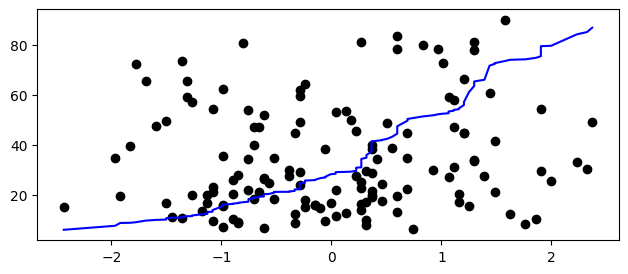

In [16]:
#linear regression with xgboosting 

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

features = filtered_ckd_df.loc[:, ["Hb", "Alb", "Cr", "CKD_stage", "UPCR", "proteinuria", "gender"]] #using CKD_stage probably doesn't make sense here
target = filtered_ckd_df.loc[:, ["eGFR"]]
reg_X_train, reg_X_test, reg_Y_train, reg_Y_test = train_test_split(features, target, test_size=0.25, random_state = 22)

reg_scaler = StandardScaler()
scaled_reg_X_train = reg_scaler.fit_transform(reg_X_train)
scaled_reg_X_test = reg_scaler.transform(reg_X_test)

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(scaled_reg_X_train, reg_Y_train)

reg_Y_pred = reg.predict(scaled_reg_X_test)
r2_score = r2_score(reg_Y_test, reg_Y_pred)

scaled_reg_X_test = np.sort(scaled_reg_X_test, axis=0)
reg_Y_pred = np.sort(reg_Y_pred, axis=0)
fig, ax = plt.subplots(figsize=(7.5,3))
ax.scatter(scaled_reg_X_test[:, 0], reg_Y_test, color = "black")
ax.plot(scaled_reg_X_test[:, 0], reg_Y_pred, color = "blue")

r2_score

In [21]:
#classification
from sklearn import tree
from sklearn.metrics import confusion_matrix, roc_auc_score

features = filtered_ckd_df.loc[:, ["Hb", "Alb", "Cr", "UPCR", "proteinuria", "gender"]]
target = filtered_ckd_df.loc[:, ["CKD_stage"]]
clf_X_train, clf_X_test, clf_Y_train, clf_Y_test = train_test_split(features, target, test_size=0.25, random_state = 22)

clf = tree.DecisionTreeClassifier(random_state = 22)
clf = clf.fit(clf_X_train, clf_Y_train)

clf_Y_pred = clf.predict(clf_X_test)
clf_Y_pred_proba = clf.predict_proba(clf_X_test)

clf_confusion_matrix = confusion_matrix(clf_Y_test, clf_Y_pred)
clf_roc_auc_score = roc_auc_score(clf_Y_test, clf_Y_pred_proba, multi_class='ovr')

clf_confusion_matrix, clf_roc_auc_score

(array([[13,  5,  1,  0,  0],
        [ 3, 16,  2,  0,  0],
        [ 1,  1, 20,  0,  0],
        [ 0,  0,  5, 45,  3],
        [ 0,  0,  0,  1, 22]], dtype=int64),
 0.8969071863909808)